# Cell Identification Using Deep Autoencoder and Support Vector Machine

# 1-Introduction
In the past few decades, deep learning neural networks have become one of the major tools for biomedical data analysis [1] such as medical images analysis [2] and bioinformatics [3]. Deep learning applications in bioinformatics has rapidly advanced since the early 2000s [3]. With increasing demand of big data analysis, different methods and applications were introduced for data compression which reduces the computation cost of the data analysis. Among such methods, image [4] and audio compression techniques have been widely used for decades [5]. Similar methods have been used to simplify gene expression profile (GEP) for further manipulation [6]. In this study, we focus on deep learning application in DNA sequencing compression using autoencoder.
Autoencoders are unsupervised neural networks use machine leaning to compress the given data (encoder) and then generate samples similar to the given data (decoder). Convolutional autoencoders are being used to reduce dimension of input data or eliminate noise from the input data. Usually, nonlinear activation functions are used in autoencoder to decrease data loss during encoding. An autoencoder is able to give a representation of output for each layer. Loss function of autoencoder defines as the distance between decoded data and input data. During training of autoencoders, the loss function will be minimized.

# 2-Material and Method
### Downloading gene expression profile from NCBI GEO
This section parses the raw gene expression data obtained from NCBI website. First, the gene expression file is downloaded from the NCBI GEO ftp link:

In [1]:
import urllib
link = 'ftp://ftp.ncbi.nlm.nih.gov/geo/datasets/GDS1nnn/GDS1615/soft/GDS1615_full.soft.gz'
file_name = urllib.request.urlretrieve(link, link.split('/')[-1])[0]
print(file_name)

GDS1615_full.soft.gz



### Input the libraries
gzip library is importet to handle compressed file downloaded from the NCBI website. numpy and pandas libraries are imported to manipulate gene expression array and input library is used for constant variables to simplify the code.

In [2]:
import gzip
import numpy as np
import pandas as pd
from matplotlib.pyplot import plot as plt

### Get subset description, subset index and gene expression data
The 'data_train_set' function is used to read subset discription, subset type and gene expression values of the compressed file download from NCBI website.  The function then returns three numpy arrays for subset description (sd), subset index (si) and gene expression (ge) table respectively.

In [3]:
def read_geo(file_name, subset_description):
    # Data input dimension to simplify is defined (None => imports all the genes unless number of genes are declared)
    data_dim = None
    with gzip.open(file_name, 'rt') as f:
        #    sd: subset description
        #    si: subset id
        #    ge: gene expression
        sd, si, ge = [], [], []
        
        #    Obtain subset description
        for line in f:
            if "!subset_description" in line:
                sd.append(line.split('=')[1].strip())
                
            elif "!subset_sample_id" in line:
                si.append(line.split('=')[1].strip().split(','))
                
            elif "!dataset_table_begin" in line:
                break
            
        subset_number = sum(len(sd) for sd in si)
            
#        Read the gene info table

        for line in f:
            if "!dataset_table_begin" in line:
                break            
    
            elif "!dataset_table_end" in line:
                break
    
            ge.append(line.split()[:2 + subset_number])
    
    ge = pd.DataFrame(ge)
    new_header = ge.iloc[0]
    ge.columns = new_header
    ge = ge[1:]
    
    return sd, si, ge

### Rearrange sd, si and ge arrays and complete parsing
Then, sd, si and ge arrays will be used to form a complete dataset with data and labels separated and prepared for further analysis:

In [4]:
def data_train_test(file_name):
    data_dim = None # indicated input data (if it is None it means all the gene expression values will be imported)
    #   Reads subsets discribtion, indexes and the whole gene expression data
    sd, si, ge = read_geo(file_name, 'all')

    #   Separate data from the gene expression table
    ge_array = np.array(ge)
    d = ge_array[:, 2:].astype(float)

    # Convert numpy array to training format for SVM solver
    data = []
    for i in range(len(d[0,:])):
        data.append(d[:data_dim,i])
    data = np.array(data)

    #   Assign numbers to subset types and make a target vector for classification
    labels = []
    for i in range(0, len(sd)):
        labels.append(len(si[i]) * [i])
    
    #   Merge the target groups (each type is a list in python, 
    #   this part merges the parts to have unit target vector)
    label_tmp = []
    for j in range(len(labels)):
        label_tmp += labels[j]
    labels = np.array(label_tmp)

    # dimension of input gene expression
    label_dimension = len(ge_array[0,2:])
    labels = labels.reshape((label_dimension,1))


    #   This line joins the data and labels as a new 2D array
    dataset = np.concatenate((data, labels), axis=1)

    #   This part randomly shuffles the data to be ready for training and testing purposes
    np.random.shuffle(dataset)

    return dataset

In [5]:
print(data_train_test(file_name))

[[105.932     26.6538    61.4062   ...   9.10682    1.31412    2.      ]
 [ 69.0926    14.7126    34.7756   ...   4.72682    0.966992   2.      ]
 [ 64.713     29.6233    40.1533   ...   2.16422    0.698281   0.      ]
 ...
 [ 76.7187    27.5782    61.1081   ...   9.09038    2.06627    1.      ]
 [105.453     27.6385    25.647    ...   3.64447    2.9912     2.      ]
 [108.099     28.5333    80.1208   ...   6.51928    1.25663    0.      ]]


# Autoencoder to compress the gene expression data
This following code is to build an autoencoder to compress the raw gene expression vectors and reconstruct them back into the similar gene expression distribution. Goal is to reduce gene expression dimension and simpliofy numerical manipulations needed for SVM classifier to determine which gene expression belongs to which type of cell.
### The libraries needed for the analysis
- tensorflow which handles the neral network analysis
- matbplotlib for visualizations

- keras which is a framework with tensor in backend:

    - Input: function creates a placeholder for input variable which is case is one gene expression vector
    - Dense: This function builds the network layers with desired number of nodes
    - Model: We use this function builds the models for encoder part and autoencoder
    - normalize: This function wil be used to normalize the input array before analysis

In [6]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import normalize
import keras

Using TensorFlow backend.


### Here, database will be imported to the code:
In this section, we read the data provided in another module which parses the raw gene expression file from the NCBI website.

Here, numpy library will be used for log(2) transformation of the input data before analysis.

Input gene expression array is imported (note that we don't import the labels here). Then $log(2)$ transform is applied on the input data and then they were normalized.

In [7]:
dataset = data_train_test(file_name)
data =np.log(dataset[:,:-1]) / np.log(2)
data = normalize(data, axis=0, order=10)

In [8]:
input_size = len(data[0, :])

80% of input data is used for training and 20% for testing accuracy of the autoencoder model. 

In [9]:
percent_80 = int(len(data[:, 0]) * 0.8)
print(percent_80)

101


In [10]:
X_train = data[:percent_80,:input_size]
L_train = dataset[:percent_80, -1]
X_test = data [percent_80:,:input_size]
L_test = dataset[percent_80:, -1]

### The neural network parameters
Starting with learning parameter, batch size which is number of samples passing to the neural network at one time and epoch number determines how many times all the data will be passed through the network. The latent vector dimension is defined which indicates compressed version of the input gene expression.

In [11]:
epoch_size = 100
batch_size = 1000
latent_dim = 30

The schematic view of the this neural network can be seen in the following figure:

<img src="files\fig_1.PNG" height="500" width="500" class="center">

### Building the neural network layers
#### Input layer
First, we define the encoder section by defining input values as follows. The input shape will be flattened as a vector with input dimension."None" means there are no data in this input, it is just a place holder.

In [12]:
input_gene_expression = Input(shape=(input_size,))

#### Encoder layer
The encoder layer will connet input layer to the latent vector.

In [13]:
encoded = Dense(latent_dim, activation='relu')(input_gene_expression)

Instructions for updating:
Colocations handled automatically by placer.


#### Decoder layer
Decoder layer is defined same as encoder layer but, it connects latent space to the output layer. 

In [14]:
decoded = Dense(input_size, activation ='sigmoid')(encoded)

#### Autoencoder model
The autoencoder model is created mapping input data to reconstructed data similar to the input.

In [15]:
autoencoder = Model(input_gene_expression, decoded)

#### Encoder model
Encoder model is created to show the latent vectors

In [16]:
encoder = Model(input_gene_expression, encoded)

### Loss function definition
Loss function of variational autoencoder is defined as the distance between input and output (reconstructed input) user mean squared error dunction:

Mean Squared Error $= \frac{1}{n}\sum_{i=1}^n.(X_i^2 - \hat{X_i^2})$

### Compiling the models
The optimizer "adam" is then used to minimize the MSE function

In [17]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

### Training the autoencoder model
Network dimensions, batch and epoch sizes and training and testing datasets are used to train the model

In [18]:
from IPython.display import clear_output
from matplotlib import pyplot as plt


class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
#         plt.plot(self.x, self.val_losses, label="val_loss")
        plt.xlabel('Epoch number')
        plt.ylabel('MSE value')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

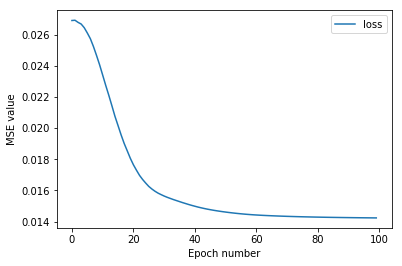

In [19]:
autoencoder.fit(X_train, X_train, epochs=epoch_size, batch_size=batch_size, \
                shuffle=True, callbacks=[PlotLosses()], validation_data=(X_test, X_test), verbose=1)

#### Note: (To avoid overfitting)
According to the loss function graph, when the loss function value converges, training process is interrupted.

# 3-Results and Discussion
In this section the first five values of the first randomly picked original gene expression is shown. And the latent vector representing that egpression is represented. Then the corresping reconstruction of gene expression is shown to compare with the original raw input. As it can be seen, the latent vector's dimension is reduced and duruing decoding, part of information is lost. 

In [20]:
latent = encoder.predict(X_test)
reconstructed = autoencoder.predict(X_test)
i = 1

print('First 10 values of the raw gene expression data:\n', X_test[i][:10], '\n')
print('Latent vector:\n', latent[i], '\n')
print('First 10 values of the reconstructed gene expression data:\n', reconstructed[i][:10])

First 10 values of the raw gene expression data:
 [0.65889387 0.61537757 0.49839267 0.64802145 0.63181147 0.54529577
 0.61839145 0.26945971 0.60349601 0.71809828] 

Latent vector:
 [-0.       -0.       -0.       -0.       -0.       -0.       -0.
 -0.       -0.       -0.       -0.       -0.       -0.       -0.
 -0.       -0.       -0.       -0.       28.093348 -0.       -0.
 -0.       -0.       -0.       -0.       -0.       -0.       -0.
 -0.       -0.      ] 

First 10 values of the reconstructed gene expression data:
 [0.57747495 0.56795114 0.5582078  0.57978284 0.5137652  0.5750063
 0.56749773 0.45039552 0.57285774 0.5429579 ]


# Support Vector Machine for Cell Type Classiffication

SVM method in 'sklean' python module will be used for SVM classification during this project.

In [21]:
from sklearn import svm

The following function will classify cell type. The input is the reconstructed gene expression vector obtained from the previous section and the is a corresponding subset type. It classifier is trained with 80% of the data and the 20% of rest of the data is for validation. 

In [22]:
def cell_classifier(input):
    model = svm.SVC(gamma=0.0001, C=10000.)
    model.fit(X_train, L_train)
    output = model.predict(input)
    return output

## Comparison
The following two vectors show the original and reconstructed cell types. 
### Test labels

In [23]:
print(cell_classifier(X_test))

[0. 2. 0. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 1. 2. 2. 2. 1. 0. 0.
 2. 2.]


### Predicted labels

In [24]:

print(L_test)

[0. 2. 0. 2. 1. 2. 2. 0. 0. 0. 2. 2. 0. 2. 2. 2. 2. 1. 2. 2. 2. 1. 0. 2.
 2. 2.]


### Accuracy
Accuracy of code is evaluated using the percentage of misclassification made by the SMV solver:

In [25]:
match_number = 0
for i in range(len(L_test)):
    if cell_classifier(X_test)[i] == L_test[i]:
        match_number += 1
acc = match_number / len(L_test)
print('Accuracy: {}'.format(acc * 100), '%')

Accuracy: 84.61538461538461 %
